In [1]:
import torch
import utils
import dlc_practical_prologue as prologue

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

from IPython.display import display,clear_output

## A. First attempts at implementing baseline methods
This notebook contains the first architectures for the classification task of miniproject 1.

### Load data and prepare it for training

In [2]:
# Download data
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

/usr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
print("Train inputs :" , train_input.shape)
print("Train targets :" , train_target.shape)
print("Train classes :" , train_classes.shape)
print("Test inputs :" , test_input.shape)
print("Test targets :" , test_target.shape)
print("Test classes :" , test_classes.shape)

Train inputs : torch.Size([1000, 2, 14, 14])
Train targets : torch.Size([1000])
Train classes : torch.Size([1000, 2])
Test inputs : torch.Size([1000, 2, 14, 14])
Test targets : torch.Size([1000])
Test classes : torch.Size([1000, 2])


In [4]:
train_input, train_target, train_classes = \
    Variable(train_input), \
    Variable(train_target), \
    Variable(train_classes) 
test_input, test_target, test_classes = \
    Variable(test_input), \
    Variable(test_target), \
    Variable(test_classes)

### Define training and evaluation functions

In [5]:
def accuracy(model, X, Y, mini_batch_size=100):
    """
    Given a trained classification model, an input set and an output set,
    this method predicts the class for the inputs and compares the predictions to the true targets.
    It counts the errors and computes the accuracy of the model on the given sets.
    
    Parameters
    ----------
    model: pytorch Model
        trained classification model
    
    X: tensor
        input data (features)
        
    Y: tensor
        target data (class)
        
    mini_batch_size: int
        the predictions are done in batches and not at once, specifies batch size
    ----------
    
    Returns
    ----------
    accuracy: float
        accuracy value, between 0 and 1
    ----------
    """
    
    nb_errors = 0
    
    # Proceed in batches
    for b in range(0, X.size(0), mini_batch_size):
        
        # Predict batch
        output = model(X.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        # Count errors in batch
        for k in range(mini_batch_size):
            if Y[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1
    
    accuracy = 1 - nb_errors/X.shape[0]
    return accuracy


def train_model(model, X, Y, tX, tY,
                mini_batch_size=100, eta=1e-3, epochs=25,
                criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    """
    This method trains a pytorch model on a given training set over the course
    of a specified number of epochs, evaluating its performance on a validation
    set at each epoch. It returns the training and validation history as a dict.
    """
    
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    optimizer = opt(model.parameters(), lr=eta)
    
    print("Training model on data : \n\
    training : ", X.shape, "->", Y.shape, "\n\
    testing  : ", tX.shape, "->", tY.shape, "\n\
    ")
    
    for e in range(epochs):
        sum_loss = 0
        
        with torch.no_grad():
            # Compute validation loss and accuracy
            val_acc = accuracy(model, tX, tY)
            history['val_acc'].append(val_acc)

            # Compute training accuracy w/o messing with training
            train_acc = accuracy(model, X, Y)
            history['train_acc'].append(train_acc)
            
            # Compute validation loss
            val_output = model(tX)
            val_loss = criterion(val_output, tY)
            history['val_loss'].append(val_loss.item())
            
        for b in range(0, X.size(0), mini_batch_size):
            # Classify batch, compute loss and perform backpropagation with parameter updates
            output = model(X.narrow(0, b, mini_batch_size))
            loss = criterion(output, Y.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()

                
        history['train_loss'].append(sum_loss)
        #clear_output(wait=True)
        if e%10 == 0 : print('Epoch ' + str(e+1) + '/' + str(epochs))
    
    return history

### Architecture 1

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
Epoch 1/50
Epoch 11/50
Epoch 21/50
Epoch 31/50
Epoch 41/50


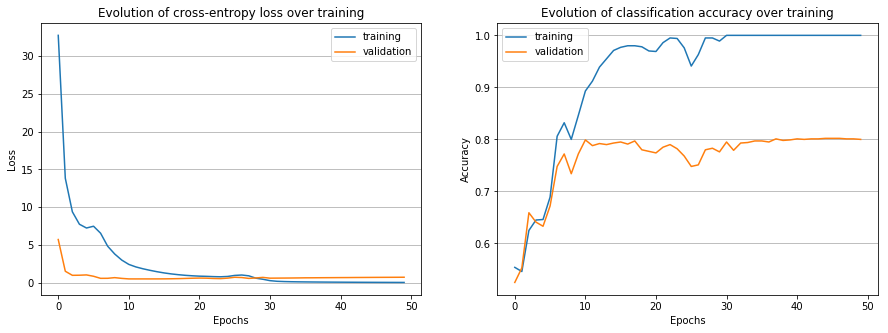

In [6]:
class ConvNet1(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.p = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
model1 = ConvNet1()
hist1 = train_model(model1, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist1)

### Architecture 2

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
Epoch 1/50
Epoch 11/50
Epoch 21/50
Epoch 31/50
Epoch 41/50


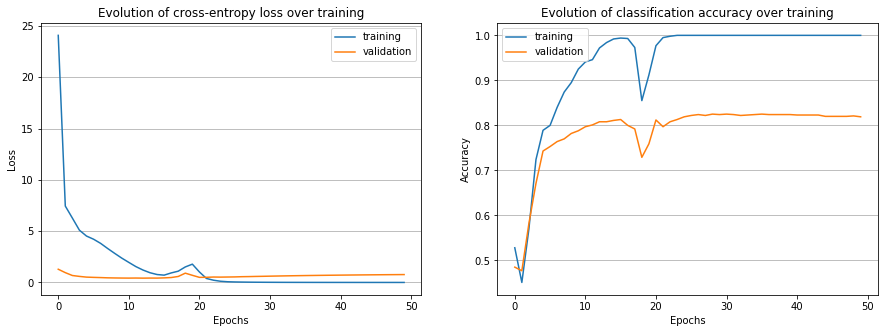

In [18]:
class ConvNet2(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 512))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
model2 = ConvNet2()
hist2 = train_model(model2, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist2)

### Architecture 3 (baseline quentin)

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 11, 11])
pool1   :  torch.Size([100, 32, 5, 5])
conv2   :  torch.Size([100, 32, 2, 2])
reshape :  torch.Size([100, 128])
fc1     :  torch.Size([100, 2]) 

Epoch 1/40
Epoch 11/40
Epoch 21/40
Epoch 31/40


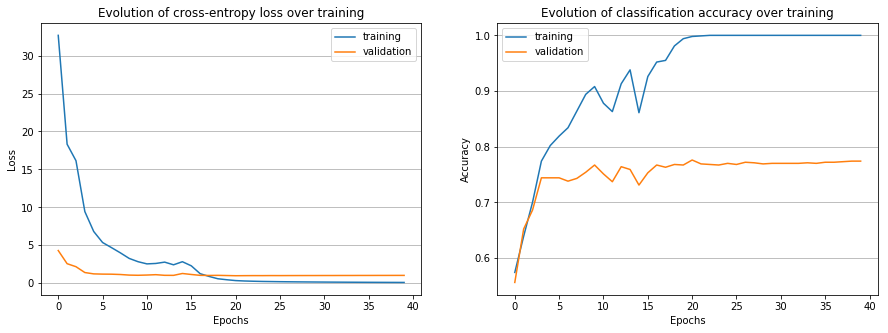

In [8]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4)
        self.fc1 = nn.Linear(128, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.pool1(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = x.view(-1, 128)
        if self.p : print ("reshape : ", x.shape)
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
        self.p=False
        return x

epochs=40
model3 = ConvNet3()
hist3 = train_model(model3, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist3)

# 4. 3 + dropout

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 11, 11])
drop    :  torch.Size([100, 32, 11, 11])
pool1   :  torch.Size([100, 32, 5, 5])
conv2   :  torch.Size([100, 32, 2, 2])
reshape :  torch.Size([100, 128])
fc1     :  torch.Size([100, 2]) 

Epoch 1/70
Epoch 11/70
Epoch 21/70
Epoch 31/70
Epoch 41/70
Epoch 51/70
Epoch 61/70


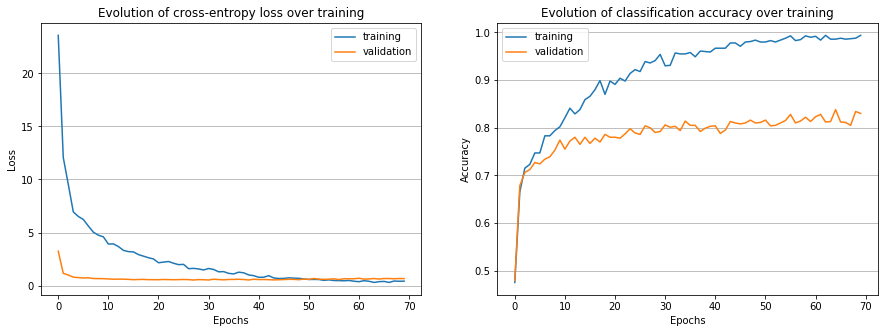

In [9]:
class ConvNet4(nn.Module):
    def __init__(self):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4)
        self.dropout = nn.Dropout(0.2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4)
        self.fc1 = nn.Linear(128, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.dropout(x)
        if self.p : print ("drop    : ", x.shape)
        x = self.pool1(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = x.view(-1, 128)
        if self.p : print ("reshape : ", x.shape)
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
        self.p=False
        return x

epochs=70
model = ConvNet4()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

### 5. = 3 + wider convolution

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 11, 11])
pool1   :  torch.Size([100, 32, 5, 5])
conv2   :  torch.Size([100, 64, 2, 2])
reshape :  torch.Size([100, 256])
fc1     :  torch.Size([100, 2]) 

Epoch 1/50
Epoch 11/50
Epoch 21/50
Epoch 31/50
Epoch 41/50


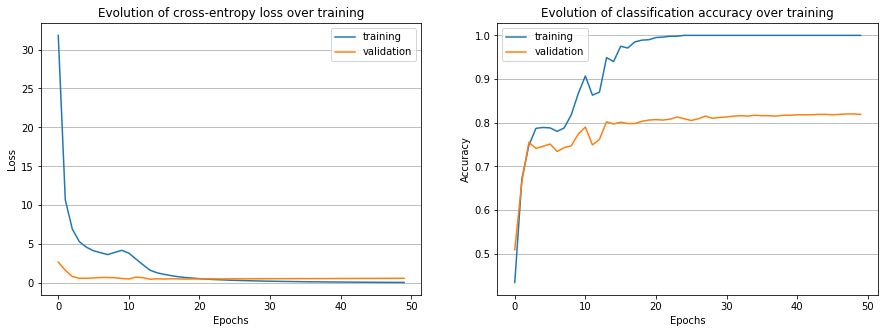

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4)
        self.fc1 = nn.Linear(256, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.pool1(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = x.view(-1, 256)
        if self.p : print ("reshape : ", x.shape)
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
        self.p=False
        return x

epochs=50
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

### 6. = 3 + wider convolution + dropout

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 11, 11])
drop    :  torch.Size([100, 32, 11, 11])
pool1   :  torch.Size([100, 32, 5, 5])
conv2   :  torch.Size([100, 64, 2, 2])
reshape :  torch.Size([100, 256])
fc1     :  torch.Size([100, 2]) 

Epoch 1/70
Epoch 11/70
Epoch 21/70
Epoch 31/70
Epoch 41/70
Epoch 51/70
Epoch 61/70


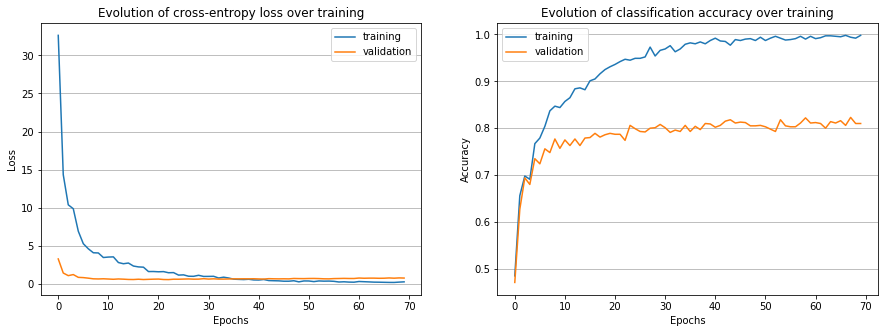

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4)
        self.dropout = nn.Dropout(0.2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4)
        self.fc1 = nn.Linear(256, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.dropout(x)
        x = F.relu(x)
        if self.p : print ("drop    : ", x.shape)
        x = self.pool1(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = x.view(-1, 256)
        if self.p : print ("reshape : ", x.shape)
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
        self.p=False
        return x

epochs=70
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

### 7. = 6 + more pooling, mode drop

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 11, 11])
drop1    :  torch.Size([100, 32, 11, 11])
pool1   :  torch.Size([100, 32, 5, 5])
conv2   :  torch.Size([100, 64, 2, 2])
pool2   :  torch.Size([100, 64, 1, 1])
drop2    :  torch.Size([100, 64, 1, 1])
reshape :  torch.Size([100, 64])
fc1     :  torch.Size([100, 2]) 

Epoch 1/70
Epoch 11/70
Epoch 21/70
Epoch 31/70
Epoch 41/70
Epoch 51/70
Epoch 61/70


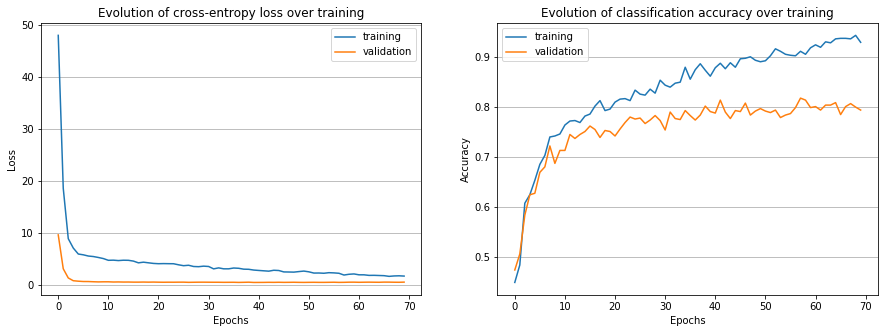

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.drop1(x)
        x = F.relu(x)
        if self.p : print ("drop1    : ", x.shape)
        x = self.pool1(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = self.pool2(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
        x = self.drop2(x)
        x = F.relu(x)
        if self.p : print ("drop2    : ", x.shape)
        x = x.view(-1, 64)
        if self.p : print ("reshape : ", x.shape)
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
        self.p=False
        return x

epochs=80
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

### 8. Deeper + no drop + no pool

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 11, 11])
conv2   :  torch.Size([100, 64, 8, 8])
conv3   :  torch.Size([100, 16, 5, 5])
reshape :  torch.Size([100, 400])
fc1     :  torch.Size([100, 2]) 

Epoch 1/35
Epoch 11/35
Epoch 21/35
Epoch 31/35


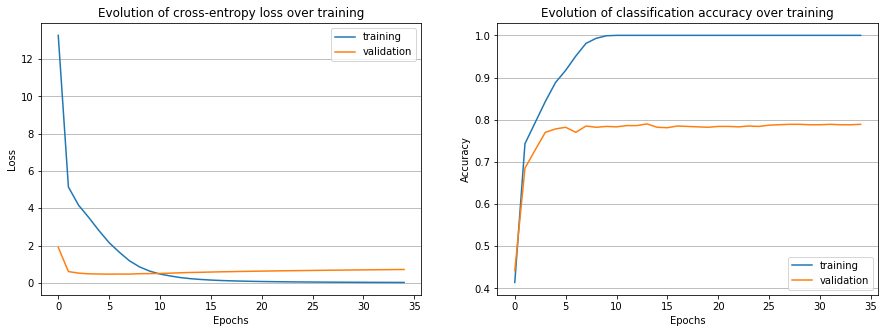

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4)
        
        self.conv3 = nn.Conv2d(64, 16, kernel_size=4)
        
        self.fc1 = nn.Linear(400, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
            
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
            
        x = self.conv3(x)
        x = F.relu(x)
        if self.p : print ("conv3   : ", x.shape)
            
        x = x.view(-1, 400)
        if self.p : print ("reshape : ", x.shape)
            
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
            
        self.p=False
        return x

epochs=35
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

### 9 =8 + pool

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 15, 15])
pool1   :  torch.Size([100, 32, 7, 7])
conv2   :  torch.Size([100, 64, 8, 8])
pool2   :  torch.Size([100, 64, 4, 4])
conv3   :  torch.Size([100, 16, 5, 5])
pool2   :  torch.Size([100, 16, 2, 2])
reshape :  torch.Size([100, 64])
fc1     :  torch.Size([100, 2]) 

Epoch 1/70
Epoch 11/70
Epoch 21/70
Epoch 31/70
Epoch 41/70
Epoch 51/70
Epoch 61/70


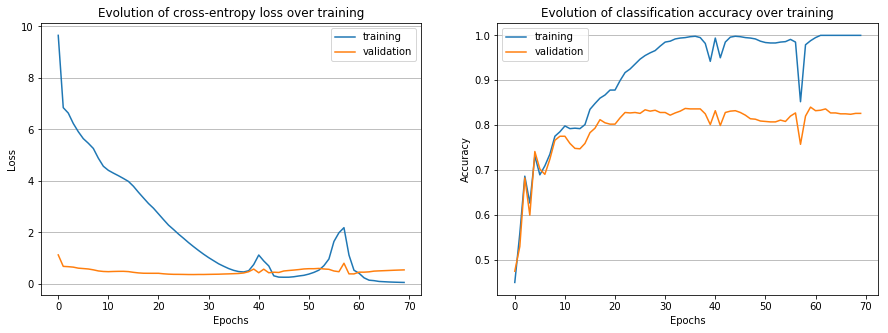

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)        
        self.conv3 = nn.Conv2d(64, 16, kernel_size=4, padding=2)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.pool1(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
            
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = self.pool2(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
            
        x = self.conv3(x)
        x = F.relu(x)
        if self.p : print ("conv3   : ", x.shape)
        x = self.pool3(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
            
        x = x.view(-1, 64)
        if self.p : print ("reshape : ", x.shape)
            
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
            
        self.p=False
        return x

epochs=80
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

### 10. =8 + pool + dropout

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 15, 15])
drop1   :  torch.Size([100, 32, 15, 15])
pool1   :  torch.Size([100, 32, 7, 7])
conv2   :  torch.Size([100, 64, 8, 8])
drop2   :  torch.Size([100, 64, 8, 8])
pool2   :  torch.Size([100, 64, 4, 4])
conv3   :  torch.Size([100, 16, 5, 5])
drop3   :  torch.Size([100, 16, 5, 5])
pool2   :  torch.Size([100, 16, 2, 2])
reshape :  torch.Size([100, 64])
fc1     :  torch.Size([100, 2]) 

Epoch 1/70
Epoch 11/70
Epoch 21/70
Epoch 31/70
Epoch 41/70
Epoch 51/70
Epoch 61/70


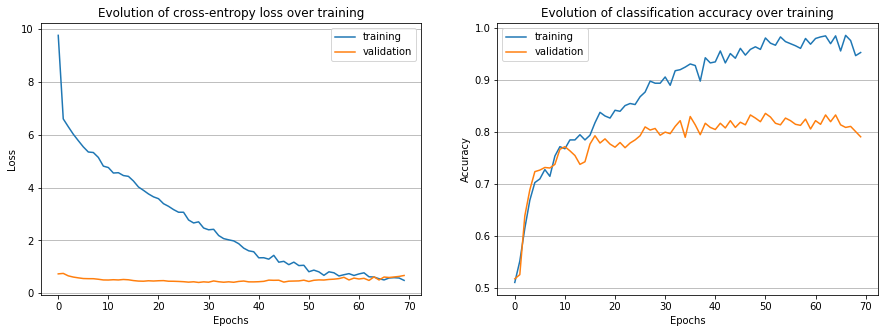

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=0)
        self.drop = nn.Dropout(0.15)
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, padding=2)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding=2)        
        self.conv3 = nn.Conv2d(64, 16, kernel_size=4, padding=2)

        self.fc1 = nn.Linear(64, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.drop(x)
        x = F.relu(x)
        if self.p : print ("drop1   : ", x.shape)
        x = self.pool(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
            
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = self.drop(x)
        x = F.relu(x)
        if self.p : print ("drop2   : ", x.shape)
        x = self.pool(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
            
        x = self.conv3(x)
        x = F.relu(x)
        if self.p : print ("conv3   : ", x.shape)
        x = self.drop(x)
        x = F.relu(x)
        if self.p : print ("drop3   : ", x.shape)
        x = self.pool(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
            
        x = x.view(-1, 64)
        if self.p : print ("reshape : ", x.shape)
            
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
            
        self.p=False
        return x

epochs=70
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)

Training model on data : 
    training :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    testing  :  torch.Size([1000, 2, 14, 14]) -> torch.Size([1000]) 
    
conv1   :  torch.Size([100, 32, 15, 15])
drop1   :  torch.Size([100, 32, 15, 15])
pool1   :  torch.Size([100, 32, 7, 7])
conv2   :  torch.Size([100, 64, 8, 8])
drop2   :  torch.Size([100, 64, 8, 8])
pool2   :  torch.Size([100, 64, 4, 4])
conv3   :  torch.Size([100, 16, 5, 5])
drop3   :  torch.Size([100, 16, 5, 5])
pool2   :  torch.Size([100, 16, 2, 2])
reshape :  torch.Size([100, 64])
fc1     :  torch.Size([100, 2]) 

Epoch 1/70
Epoch 11/70
Epoch 21/70
Epoch 31/70
Epoch 41/70
Epoch 51/70
Epoch 61/70


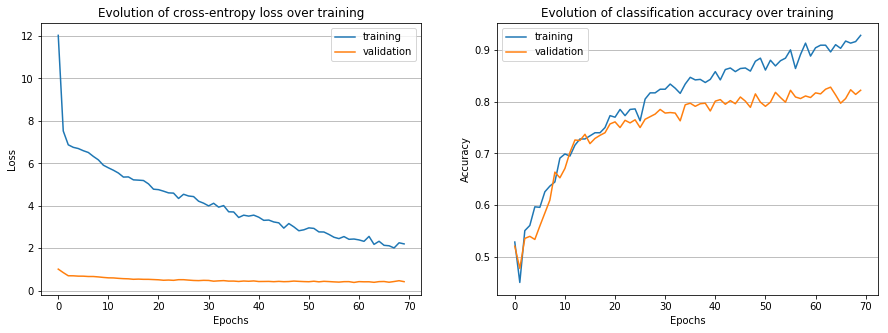

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=0)
        self.drop = nn.Dropout(0.35)
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, padding=2)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding=2)        
        self.conv3 = nn.Conv2d(64, 16, kernel_size=4, padding=2)

        self.fc1 = nn.Linear(64, 2)
        self.p = True

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        if self.p : print ("conv1   : ", x.shape)
        x = self.drop(x)
        x = F.relu(x)
        if self.p : print ("drop1   : ", x.shape)
        x = self.pool(x)
        x = F.relu(x)
        if self.p : print ("pool1   : ", x.shape)
            
        x = self.conv2(x)
        x = F.relu(x)
        if self.p : print ("conv2   : ", x.shape)
        x = self.drop(x)
        x = F.relu(x)
        if self.p : print ("drop2   : ", x.shape)
        x = self.pool(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
            
        x = self.conv3(x)
        x = F.relu(x)
        if self.p : print ("conv3   : ", x.shape)
        x = self.drop(x)
        x = F.relu(x)
        if self.p : print ("drop3   : ", x.shape)
        x = self.pool(x)
        x = F.relu(x)
        if self.p : print ("pool2   : ", x.shape)
            
        x = x.view(-1, 64)
        if self.p : print ("reshape : ", x.shape)
            
        x = self.fc1(x)
        if self.p : print ("fc1     : ", x.shape, "\n")
            
        self.p=False
        return x

epochs=80
model = ConvNet()
hist = train_model(model, train_input, train_target, test_input, test_target, eta=0.0005, epochs=epochs)
utils.plot_hist(hist)